In [ ]:
!pip install -q kaggle
from google.colab import files

# Upload your Kaggle API key (kaggle.json) file
files.upload()

# Move the uploaded file to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the Kaggle API key
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sid321axn/malicious-urls-dataset

 30% 5.00M/16.9M [00:00<00:00, 49.0MB/s]
100% 16.9M/16.9M [00:00<00:00, 118MB/s] 


In [ ]:
!unzip malicious-urls-dataset.zip

Archive:  malicious-urls-dataset.zip
  inflating: malicious_phish.csv     


In [ ]:
!ls

malicious_phish.csv  malicious-urls-dataset.zip  sample_data


In [ ]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv("malicious_phish.csv")


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'type' is the column you want to one-hot encode
df = pd.read_csv("malicious_phish.csv")

# Converting type of columns to category
df['type'] = df['type'].astype('category')

# Create an instance of One-hot-encoder
enc = OneHotEncoder(sparse=False, drop='first')

# Reshape the 'type' column and apply one-hot encoding
encoded_data = enc.fit_transform(df[['type']])

# Create new column names for the one-hot encoded columns
new_columns = [f"{col}_encoded" for col in df['type'].cat.categories[1:]]

# Create a DataFrame with the encoded data and new column names
encoded_df = pd.DataFrame(encoded_data, columns=new_columns)

# Concatenate the original DataFrame and the one-hot encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop the original 'type' column
#df.drop(['type'], axis=1, inplace=True)

print(df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


                                                      url        type  \
0                                        br-icloud.com.br    phishing   
1                     mp3raid.com/music/krizz_kaliko.html      benign   
2                         bopsecrets.org/rexroth/cr/1.htm      benign   
3       http://www.garage-pirenne.be/index.php?option=...  defacement   
4       http://adventure-nicaragua.net/index.php?optio...  defacement   
...                                                   ...         ...   
651186            xbox360.ign.com/objects/850/850402.html    phishing   
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing   
651188         www.gamespot.com/xbox360/action/deadspace/    phishing   
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing   
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing   

        defacement_encoded  malware_encoded  phishing_encoded  
0                      0.0              0.0               1

##Classifiers

**Kmeans with KNN Without hyperparaeter**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features for KNN
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Instantiate K-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the KNN classifier
knn_classifier.fit(X_train[['malware_encoded', 'phishing_encoded']], y_train)

# Create a mesh grid
h = .02  # Step size in the mesh
x_min, x_max = X_with_clusters['malware_encoded'].min() - 1, X_with_clusters['malware_encoded'].max() + 1
y_min, y_max = X_with_clusters['phishing_encoded'].min() - 1, X_with_clusters['phishing_encoded'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class for each point in the mesh grid
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the result to the mesh grid shape
Z = Z.reshape(xx.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<ipython-input-10-d8f15877fb3a>:11: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['malware_encoded'], X_test['phishing_encoded'], c=y_test, edgecolors='k', marker='x', s=100, label='Test Set')


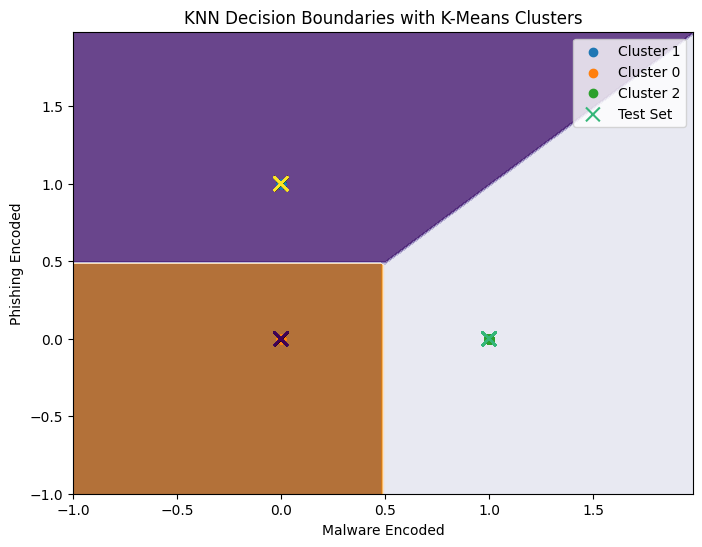

In [ ]:
# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.PuOr, alpha=0.8)

# Scatter plot for each cluster
for cluster_label in df['cluster'].unique():
    cluster_points = X_with_clusters[df['cluster'] == cluster_label]
    plt.scatter(cluster_points['malware_encoded'], cluster_points['phishing_encoded'], label=f'Cluster {cluster_label}')

# Scatter plot for testing set with predictions
plt.scatter(X_test['malware_encoded'], X_test['phishing_encoded'], c=y_test, edgecolors='k', marker='x', s=100, label='Test Set')

plt.xlabel('Malware Encoded')
plt.ylabel('Phishing Encoded')
plt.title('KNN Decision Boundaries with K-Means Clusters')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = knn_classifier.predict(X_test[['malware_encoded', 'phishing_encoded']])
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8533158270564116
Confusion Matrix:
[[85778     0     0     0]
 [19104     0     0     0]
 [    0     0  6521     0]
 [    0     0     0 18836]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     85778
           1       0.00      0.00      0.00     19104
           2       1.00      1.00      1.00      6521
           3       1.00      1.00      1.00     18836

    accuracy                           0.85    130239
   macro avg       0.70      0.75      0.72    130239
weighted avg       0.73      0.85      0.79    130239



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8533158270564116


Text(0.5, 1.0, 'Confusion Matrix')

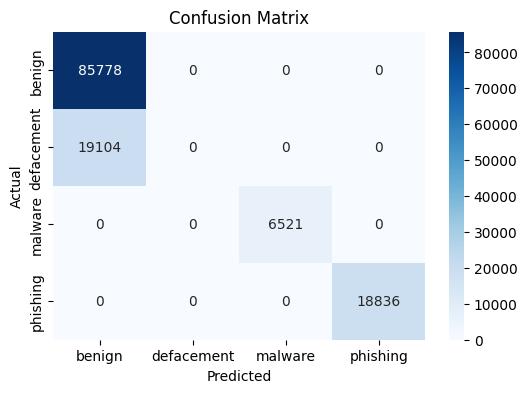

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

**Kmeans with KNN With Hyperparameter**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
<ipython-input-18-9f375dbd0f4c>:63: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['malware_encoded'], X_test['phishing_encoded'], c=y_test, edgecolors='k', marker='x', s=100, label='Test Set')


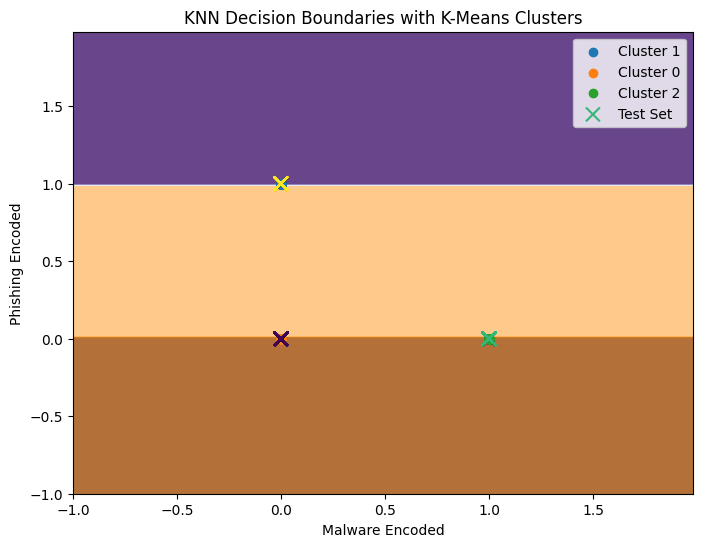

In [ ]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features for KNN
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Specify hyperparameters for KNN
n_neighbors = 5  # You can try different values
weights = 'distance'  # You can try 'uniform' or other values

# Instantiate K-Nearest Neighbors (KNN) classifier with specified hyperparameters
knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

# Train the KNN classifier
knn_classifier.fit(X_train[['malware_encoded', 'phishing_encoded', 'cluster']], y_train)

# Create a mesh grid
h = .02  # Step size in the mesh
x_min, x_max = X_with_clusters['malware_encoded'].min() - 1, X_with_clusters['malware_encoded'].max() + 1
y_min, y_max = X_with_clusters['phishing_encoded'].min() - 1, X_with_clusters['phishing_encoded'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class for each point in the mesh grid
Z = knn_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

# Reshape the result to the mesh grid shape
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.PuOr, alpha=0.8)

# Scatter plot for each cluster
for cluster_label in df['cluster'].unique():
    cluster_points = X_with_clusters[df['cluster'] == cluster_label]
    plt.scatter(cluster_points['malware_encoded'], cluster_points['phishing_encoded'], label=f'Cluster {cluster_label}')

# Scatter plot for testing set with predictions
plt.scatter(X_test['malware_encoded'], X_test['phishing_encoded'], c=y_test, edgecolors='k', marker='x', s=100, label='Test Set')

plt.xlabel('Malware Encoded')
plt.ylabel('Phishing Encoded')
plt.title('KNN Decision Boundaries with K-Means Clusters')
plt.legend()

plt.show()

Accuracy: 0.8533158270564116


Text(0.5, 1.0, 'Confusion Matrix')

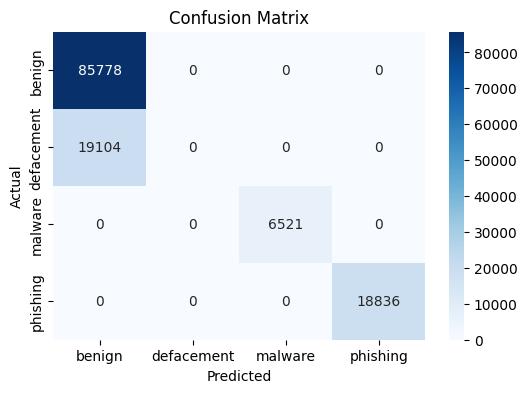

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [ ]:
# Print the classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     85778
           1       0.00      0.00      0.00     19104
           2       1.00      1.00      1.00      6521
           3       1.00      1.00      1.00     18836

    accuracy                           0.85    130239
   macro avg       0.70      0.75      0.72    130239
weighted avg       0.73      0.85      0.79    130239



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**KMeans with SVM without Hyperparameter**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SVM Classifier Accuracy: 0.8533158270564116


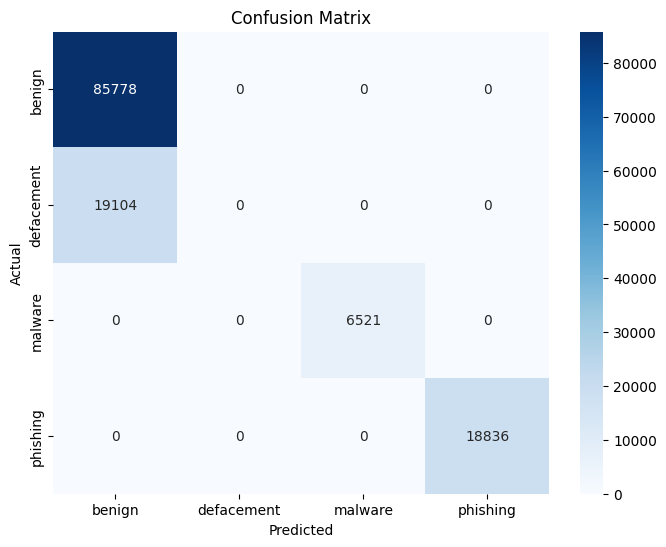

In [ ]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Instantiate Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict using the trained SVM classifier
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Classifier Accuracy:", accuracy_svm)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     85778
           1       0.00      0.00      0.00     19104
           2       1.00      1.00      1.00      6521
           3       1.00      1.00      1.00     18836

    accuracy                           0.85    130239
   macro avg       0.70      0.75      0.72    130239
weighted avg       0.73      0.85      0.79    130239



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
svm_classifier.fit(X_train, y_train)

# Obtain predictions on the meshgrid
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

# Reshape the predictions to match the meshgrid shape
Z = Z.reshape(xx.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
from matplotlib.colors import ListedColormap

# Create a meshgrid for plotting decision boundaries
h = 0.02  # step size in the mesh
x_min, x_max = X_with_clusters.iloc[:, 0].min() - 1, X_with_clusters.iloc[:, 0].max() + 1
y_min, y_max = X_with_clusters.iloc[:, 1].min() - 1, X_with_clusters.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain predictions on the meshgrid
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

# Reshape the predictions to match the meshgrid shape
Z = Z.reshape(xx.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


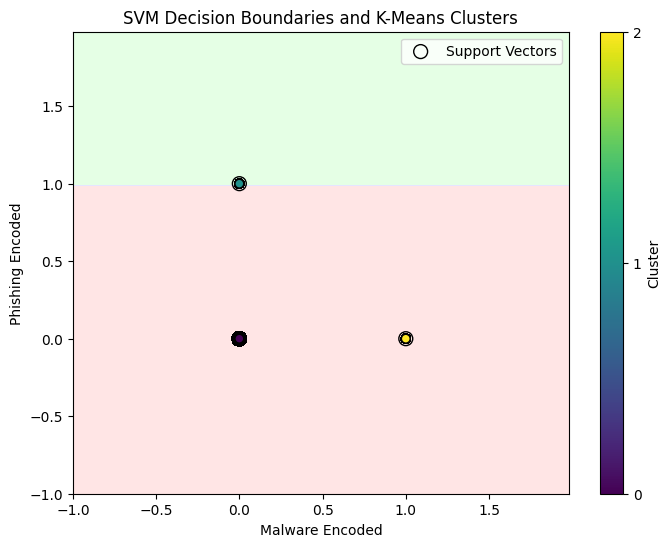

In [ ]:
# Plot the decision boundaries
plt.figure(figsize=(8, 6))
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)

# Scatter plot of data points with K-Means clusters
scatter = plt.scatter(X_with_clusters.iloc[:, 0], X_with_clusters.iloc[:, 1], c=df['cluster'], cmap='viridis', edgecolors='k', s=40)  # Use a valid colormap like 'viridis'
plt.colorbar(scatter, ticks=[0, 1, 2], label='Cluster')

# Mark support vectors
plt.scatter(svm_classifier.support_vectors_[:, 0], svm_classifier.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

plt.xlabel('Malware Encoded')
plt.ylabel('Phishing Encoded')
plt.title('SVM Decision Boundaries and K-Means Clusters')
plt.legend()
plt.show()

**Kmeans With SVM With Hyperparameter**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables
X = df[['malware_encoded', 'phishing_encoded']]

# Target Variable
y = df['type_encoded']

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Use K-Means clusters as features
X_with_clusters = df[['malware_encoded', 'phishing_encoded', 'cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Instantiate Support Vector Machine (SVM) classifier with hyperparameters
param_grid_svm = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
svm_classifier = SVC()
svm_grid_search = GridSearchCV(svm_classifier, param_grid_svm, cv=5)
svm_grid_search.fit(X_train, y_train)

print("Best SVM Hyperparameters:", svm_grid_search.best_params_)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Predict using the trained SVM classifier
y_pred_svm = svm_classifier.predict(X_test)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Classifier Accuracy:", accuracy_svm)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

In [ ]:
from matplotlib.colors import ListedColormap

# Create a meshgrid for plotting decision boundaries
h = 0.02  # step size in the mesh
x_min, x_max = X_with_clusters.iloc[:, 0].min() - 1, X_with_clusters.iloc[:, 0].max() + 1
y_min, y_max = X_with_clusters.iloc[:, 1].min() - 1, X_with_clusters.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain predictions on the meshgrid
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

# Reshape the predictions to match the meshgrid shape
Z = Z.reshape(xx.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


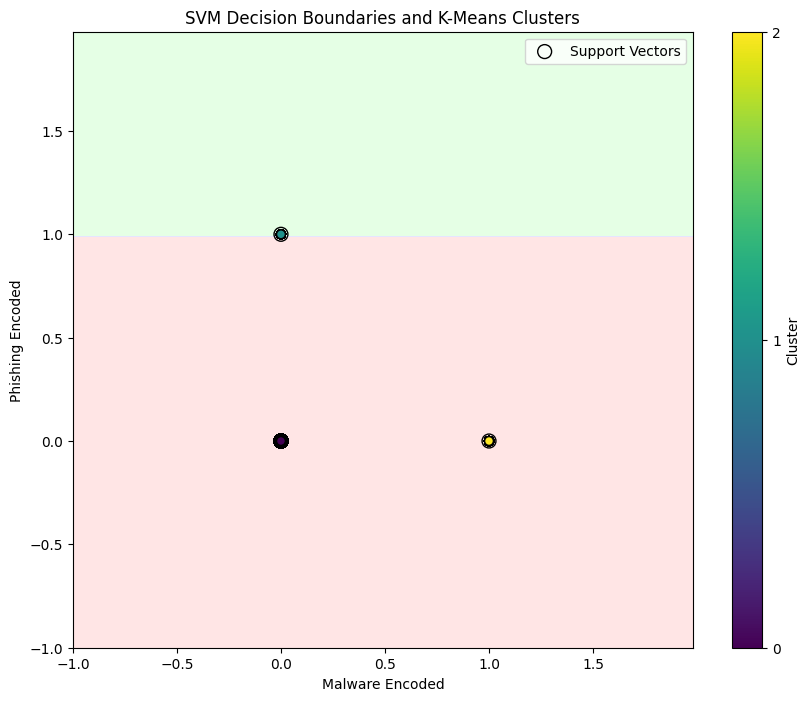

In [ ]:
# Plot the decision boundaries
plt.figure(figsize=(8, 6))
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)

# Scatter plot of data points with K-Means clusters
scatter = plt.scatter(X_with_clusters.iloc[:, 0], X_with_clusters.iloc[:, 1], c=df['cluster'], cmap='viridis', edgecolors='k', s=40)  # Use a valid colormap like 'viridis'
plt.colorbar(scatter, ticks=[0, 1, 2], label='Cluster')

# Mark support vectors
plt.scatter(svm_classifier.support_vectors_[:, 0], svm_classifier.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

plt.xlabel('Malware Encoded')
plt.ylabel('Phishing Encoded')
plt.title('SVM Decision Boundaries and K-Means Clusters')
plt.legend()
plt.show()

##Fuzzy C-means With KNN

**Fuzzy C-means with KNN without Hyperparameter**

In [ ]:
!pip install fuzzy-c-means

  Attempting uninstall: typer
    Found existing installation: typer 0.9.0
    Uninstalling typer-0.9.0:
      Successfully uninstalled typer-0.9.0
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
bigframes 0.15.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


KNN Classifier Accuracy: 0.8533158270564116


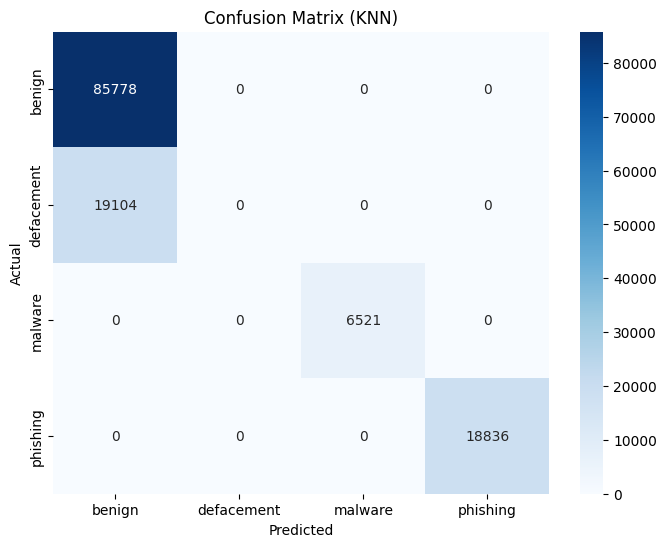

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from fcmeans import FCM
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables for FCM clustering
features_for_fcm = ['malware_encoded', 'phishing_encoded']

# Target Variable for FCM clustering
y_fcm = df['type_encoded']

# Extract features for FCM clustering
X_fcm = df[features_for_fcm]

# Standardize features for FCM clustering
scaler_fcm = StandardScaler()
X_fcm_scaled = scaler_fcm.fit_transform(X_fcm)

# Apply Fuzzy C-means clustering
fcm = FCM(n_clusters=3)
fcm.fit(X_fcm_scaled)

# Get cluster memberships
fcm_clusters = fcm.u.argmax(axis=1)

# Use Fuzzy C-means clusters as features
df['fcm_cluster'] = fcm_clusters
X_with_fcm_clusters = df[['malware_encoded', 'phishing_encoded', 'fcm_cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_fcm_clusters, y_fcm, test_size=0.2, random_state=42)

# Instantiate k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Predict using the trained KNN classifier
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the KNN classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)

# Plot confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90     85778
           1       0.00      0.00      0.00     19104
           2       1.00      1.00      1.00      6521
           3       1.00      1.00      1.00     18836

    accuracy                           0.85    130239
   macro avg       0.70      0.75      0.72    130239
weighted avg       0.73      0.85      0.79    130239



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


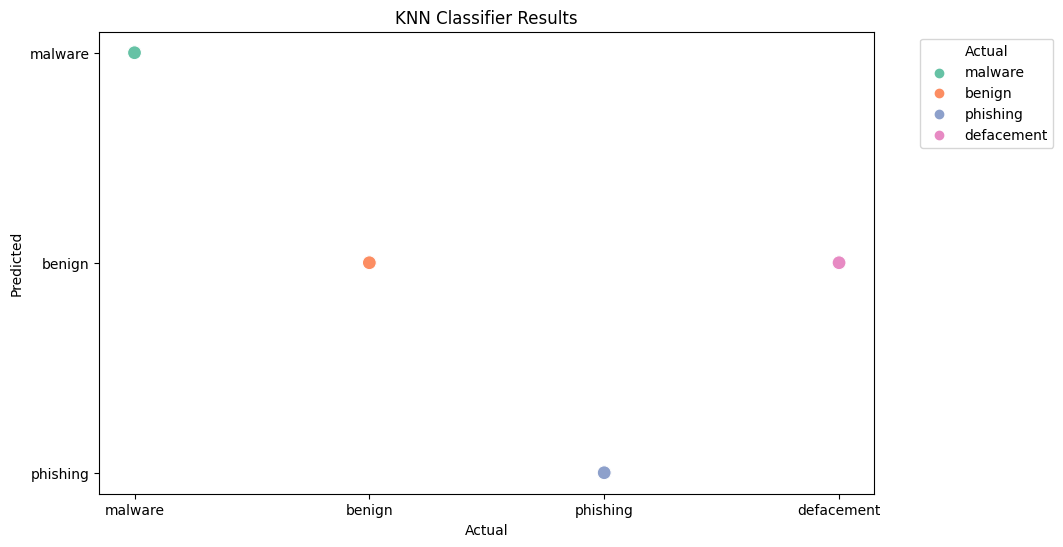

In [ ]:
# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': le.inverse_transform(y_test), 'Predicted': le.inverse_transform(y_pred_knn)})

# Plot a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', hue='Actual', palette='Set2', s=100)
plt.title('KNN Classifier Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(title='Actual', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

KNN Classifier Accuracy: 0.9450625388708451


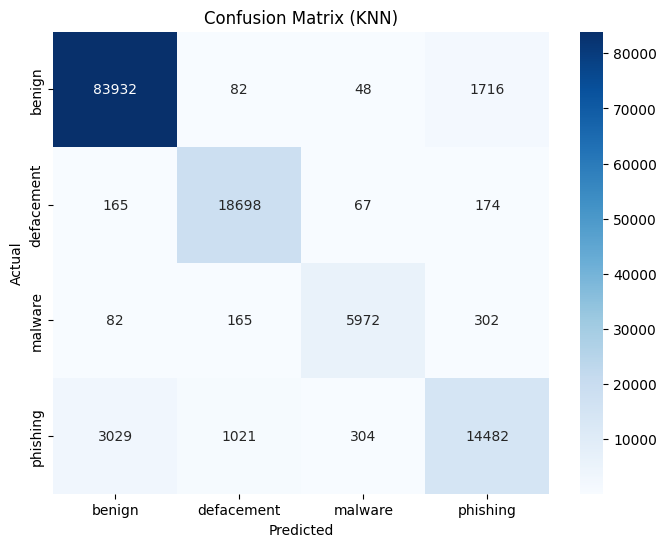

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from fcmeans import FCM
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Features for FCM clustering
features_for_fcm = ['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']

# Extract features for FCM clustering
X_fcm = df[features_for_fcm]

# Standardize features for FCM clustering
scaler_fcm = StandardScaler()
X_fcm_scaled = scaler_fcm.fit_transform(X_fcm)

# Apply Fuzzy C-means clustering
fcm = FCM(n_clusters=3)
fcm.fit(X_fcm_scaled)

# Get cluster memberships
fcm_clusters = fcm.u.argmax(axis=1)

# Use Fuzzy C-means clusters as features
df['fcm_cluster'] = fcm_clusters
X_with_fcm_clusters = df[features_for_fcm + ['fcm_cluster']]

# Separate FCM clusters from target variable
X_fcm_clusters = df[features_for_fcm + ['fcm_cluster']]
y_fcm_clusters = df['type_encoded']

# Split the dataset into training and testing sets for KNN
X_train, X_test, y_train, y_test = train_test_split(X_fcm_clusters, y_fcm_clusters, test_size=0.2, random_state=42)

# Instantiate k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Predict using the trained KNN classifier
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the KNN classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)

# Plot confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()


**Fuzzy C-means with KNN with Hyperparameter**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from fcmeans import FCM
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import ParameterGrid

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Features for FCM clustering
features_for_fcm = ['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']

# Extract features for FCM clustering
X_fcm = df[features_for_fcm]

# Standardize features for FCM clustering
scaler_fcm = StandardScaler()
X_fcm_scaled = scaler_fcm.fit_transform(X_fcm)

# Perform a manual search for the best FCM hyperparameters
best_accuracy = 0.0
best_fcm_model = None

fcm_params = {
    'n_clusters': [3, 4, 5],
    'm': [1.5, 2.0, 2.5]
}

for params in ParameterGrid(fcm_params):
    fcm = FCM(**params)
    fcm.fit(X_fcm_scaled)
    fcm_clusters = fcm.u.argmax(axis=1)

    # Use Fuzzy C-means clusters as features
    df['fcm_cluster'] = fcm_clusters
    X_with_fcm_clusters = df[features_for_fcm + ['fcm_cluster']]

    # Separate FCM clusters from target variable
    X_fcm_clusters = df[features_for_fcm + ['fcm_cluster']]
    y_fcm_clusters = df['type_encoded']

    # Split the dataset into training and testing sets for KNN
    X_train, X_test, y_train, y_test = train_test_split(X_fcm_clusters, y_fcm_clusters, test_size=0.2, random_state=42)

    # Instantiate k-Nearest Neighbors (KNN) classifier with hyperparameters
    knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    knn_classifier = KNeighborsClassifier()

    for knn_params in ParameterGrid(knn_params):
        knn_classifier.set_params(**knn_params)
        knn_classifier.fit(X_train, y_train)
        y_pred_knn = knn_classifier.predict(X_test)
        accuracy_knn = accuracy_score(y_test, y_pred_knn)

        if accuracy_knn > best_accuracy:
            best_accuracy = accuracy_knn
            best_fcm_model = fcm
            best_knn_params = knn_params

# Get best KNN model from the manual search
best_knn_classifier = KNeighborsClassifier(**best_knn_params)
best_knn_classifier.fit(X_train, y_train)

# Predict using the best KNN classifier
y_pred_knn = best_knn_classifier.predict(X_test)

# Evaluate the best KNN classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Best KNN Classifier Accuracy:", accuracy_knn)

# Plot confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()



KNN Classifier Accuracy: 0.8533158270564116


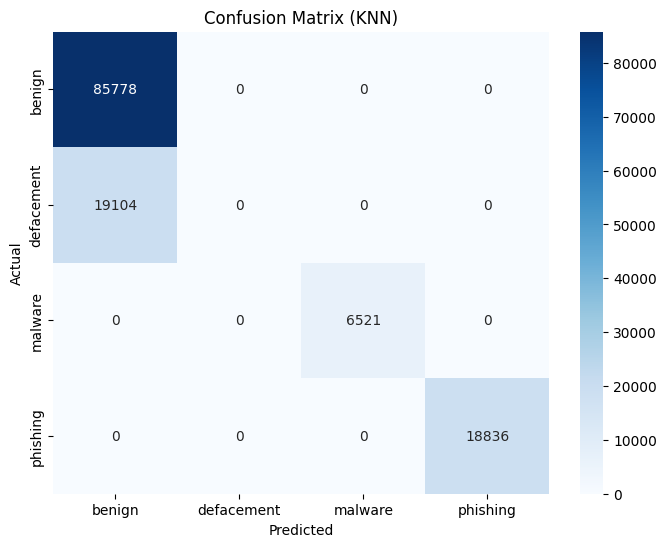

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from fcmeans import FCM

# Assuming 'type' is a categorical target variable
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

# Predictor Variables for FCM clustering
features_for_fcm = ['malware_encoded', 'phishing_encoded']

# Target Variable for FCM clustering
y_fcm = df['type_encoded']



# Extract features for FCM clustering
X_fcm = df[features_for_fcm]

# Standardize features for FCM clustering
scaler_fcm = StandardScaler()
X_fcm_scaled = scaler_fcm.fit_transform(X_fcm)

# Apply Fuzzy C-means clustering
fcm = FCM(n_clusters=3)
fcm.fit(X_fcm_scaled)

# Get cluster memberships
fcm_clusters = fcm.u.argmax(axis=1)

# Use Fuzzy C-means clusters as features
df['fcm_cluster'] = fcm_clusters
X_with_fcm_clusters = df[['malware_encoded', 'phishing_encoded', 'fcm_cluster']]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_fcm_clusters, y_fcm, test_size=0.2, random_state=42)

# Instantiate k-Nearest Neighbors (KNN) classifier with different hyperparameters
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

# Train the KNN classifier
knn_classifier.fit(X_train, y_train)

# Predict using the trained KNN classifier
y_pred_knn = knn_classifier.predict(X_test)

# Evaluate the KNN classifier
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Classifier Accuracy:", accuracy_knn)

# Plot confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


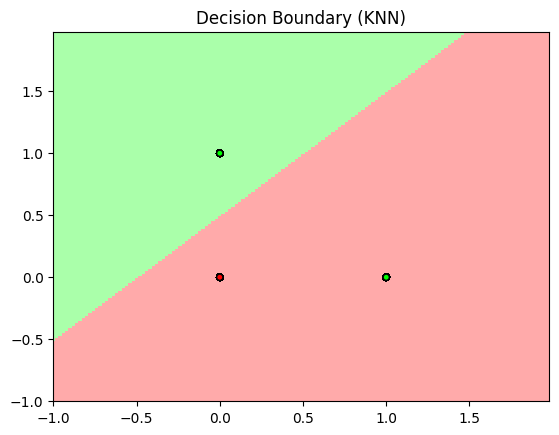

In [ ]:
def plot_decision_boundary_knn(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (KNN)")
    plt.show()

# Assuming X_test contains the same features used for training (malware_encoded, phishing_encoded, fcm_cluster)
plot_decision_boundary_knn(X_test.values, y_test.values, knn_classifier)


##Bayesian Classifier

**Bayesian Classifier without hyperparameter**

Gaussian Naive Bayes Accuracy: 78.19%


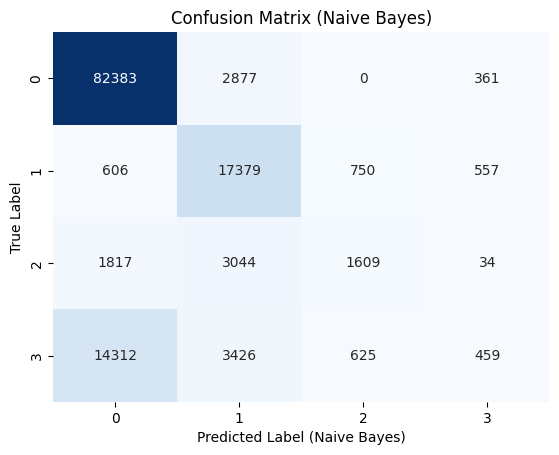

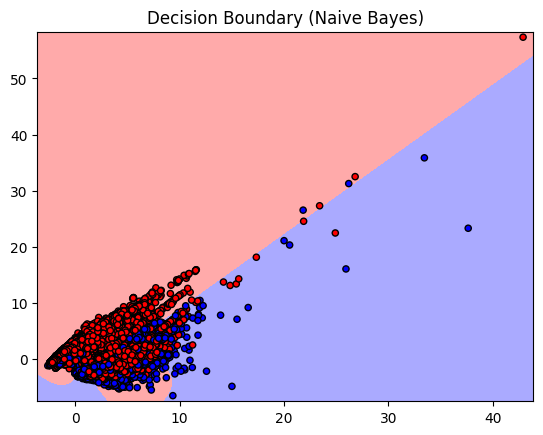

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

nb_classifier = GaussianNB()
nb_classifier.fit(X_train_pca, y_train)

y_pred_nb = nb_classifier.predict(X_test_pca)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%')

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Naive Bayes)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

def plot_decision_boundary_nb(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Naive Bayes)")
    plt.show()

plot_decision_boundary_nb(X_test_pca, y_test, nb_classifier, h=0.02)

**Bayesian Classifier with Hyperparameter**

Gaussian Naive Bayes Accuracy: 78.25%


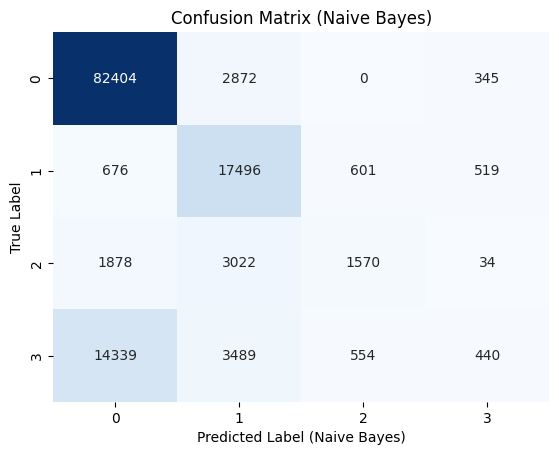

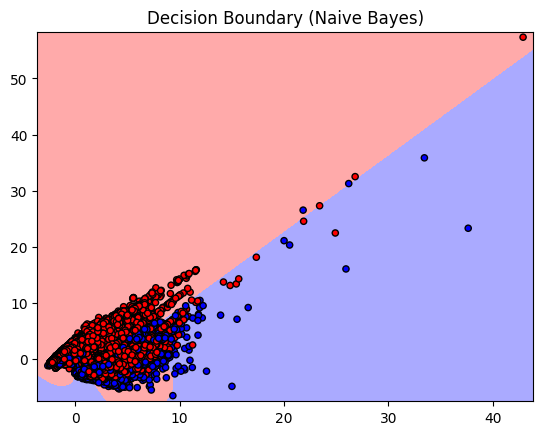

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}

nb_classifier = GaussianNB()

grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_var_smoothing = grid_search.best_params_['var_smoothing']

nb_classifier = GaussianNB(var_smoothing=best_var_smoothing)
nb_classifier.fit(X_train_pca, y_train)

y_pred_nb = nb_classifier.predict(X_test_pca)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%')

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Naive Bayes)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

def plot_decision_boundary_nb(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Naive Bayes)")
    plt.show()

plot_decision_boundary_nb(X_test_pca, y_test, nb_classifier, h=0.02)


#Naive Bayes Classifier

**Naïve Bayes Classifier without Hyperparameter**

Gaussian Naive Bayes Accuracy: 78.19%


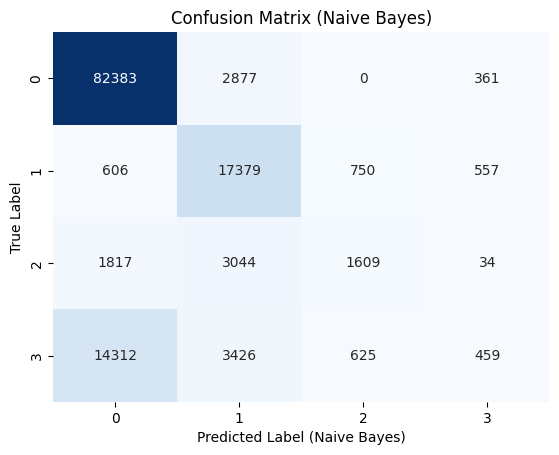

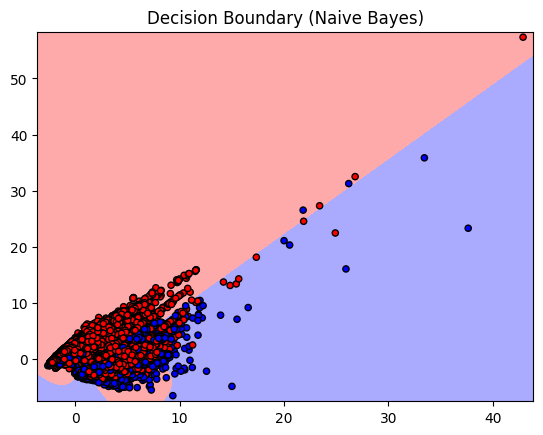

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

nb_classifier = GaussianNB()

nb_classifier.fit(X_train_pca, y_train)

y_pred_nb = nb_classifier.predict(X_test_pca)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%')

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Naive Bayes)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

def plot_decision_boundary_nb(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Naive Bayes)")
    plt.show()

plot_decision_boundary_nb(X_test_pca, y_test, nb_classifier, h=0.02)


**Naïve Bayes Classifier with Hyperparameters**

Gaussian Naive Bayes Accuracy: 78.25%


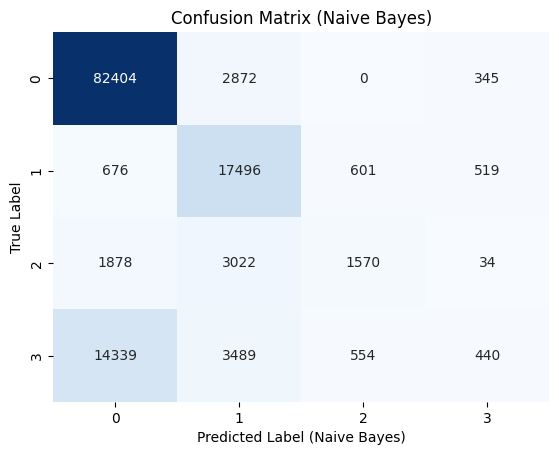

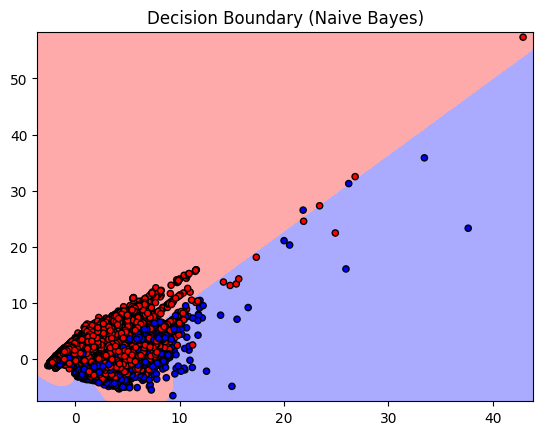

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}

nb_classifier = GaussianNB()

grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_var_smoothing = grid_search.best_params_['var_smoothing']

nb_classifier = GaussianNB(var_smoothing=best_var_smoothing)
nb_classifier.fit(X_train_pca, y_train)

y_pred_nb = nb_classifier.predict(X_test_pca)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_nb * 100:.2f}%')


cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Naive Bayes)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()

def plot_decision_boundary_nb(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Naive Bayes)")
    plt.show()

plot_decision_boundary_nb(X_test_pca, y_test, nb_classifier, h=0.02)


##Decision Tree


**Decision Tree without Hyperparameter**

Decision Tree Accuracy: 89.48%
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     85621
           1       0.85      0.86      0.86     19292
           2       0.90      0.89      0.89      6504
           3       0.72      0.66      0.68     18822

    accuracy                           0.89    130239
   macro avg       0.85      0.84      0.85    130239
weighted avg       0.89      0.89      0.89    130239



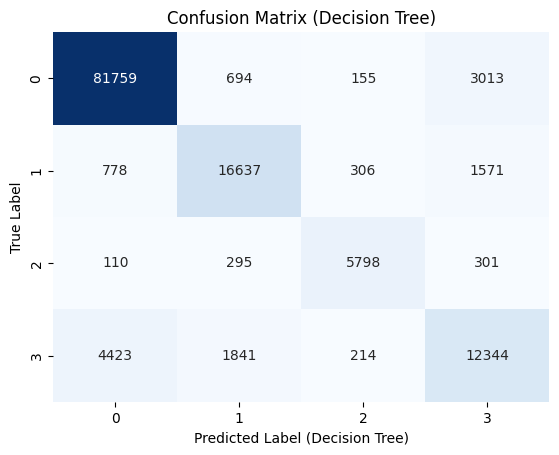

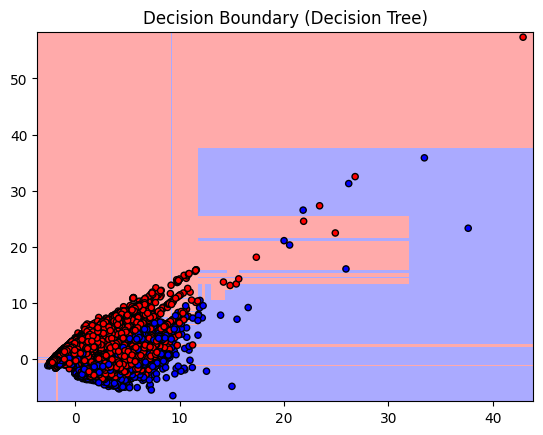

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

# Standardize features for Decision Trees
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for visualization and feature reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test_pca)

# Evaluate Decision Tree performance
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt * 100:.2f}%')

# Print precision, recall, and F1-score
print(classification_report(y_test, y_pred_dt))

# Plot confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Decision Tree)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

# Visualize decision boundary for Decision Tree
def plot_decision_boundary_dt(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Decision Tree)")
    plt.show()

# Plot decision boundary for Decision Tree using the first two principal components
plot_decision_boundary_dt(X_test_pca, y_test, dt_classifier, h=0.02)

In [ ]:
df=pd.read_csv('malicious_phish.csv')

print(df.shape)
df.head()

(651191, 2)


url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

In [ ]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
import tld

In [ ]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

#pip install googlesearch-python

from googlesearch import search

def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df['count-letters']= df['url'].apply(lambda i: letter_count(i))

# pip install tld

from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

**Decision Tree With Hyperparameter**

Decision Tree Accuracy: 90.22%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     85621
           1       0.82      0.91      0.86     19292
           2       0.91      0.84      0.87      6504
           3       0.81      0.61      0.70     18822

    accuracy                           0.90    130239
   macro avg       0.87      0.83      0.85    130239
weighted avg       0.90      0.90      0.90    130239



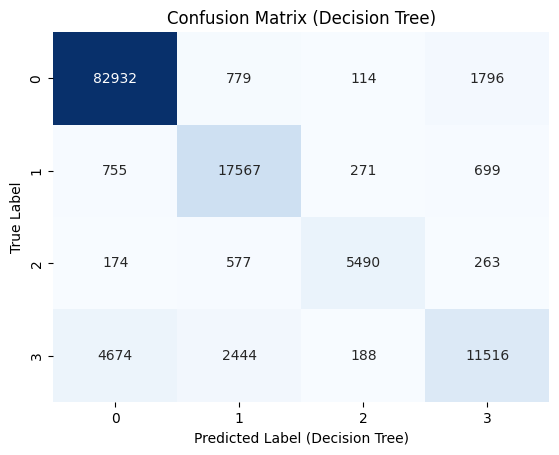

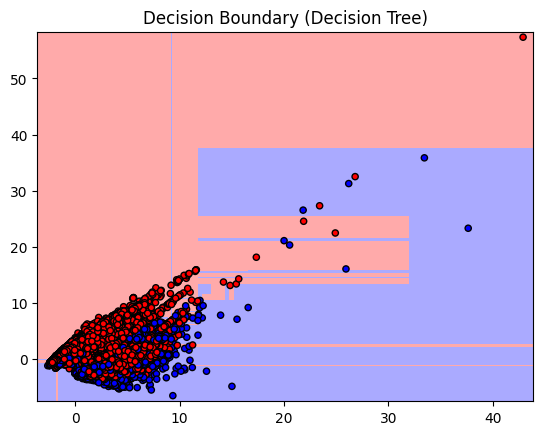

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_classifier = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

best_params = grid_search.best_params_

dt_classifier = DecisionTreeClassifier(**best_params, random_state=42)
dt_classifier.fit(X_train_pca, y_train)

y_pred_dt = dt_classifier.predict(X_test_pca)


accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt * 100:.2f}%')


print(classification_report(y_test, y_pred_dt))


cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Decision Tree)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()

def plot_decision_boundary_dt(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Decision Tree)")
    plt.show()


plot_decision_boundary_dt(X_test_pca, y_test, dt_classifier, h=0.02)


**Random Forest**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

In [ ]:
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]
#Target Variable
y = df['type_code']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [ ]:
# Random Forest Model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt')
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.98      0.98     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.99      0.95      0.97      6504
     malware       0.91      0.86      0.88     18822

    accuracy                           0.97    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.966


**XG Boost**

In [ ]:
from sklearn import metrics
#XGboost
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train,y_train)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.98      0.91      0.94      6504
     malware       0.91      0.83      0.87     18822

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.962


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming 'type' is a categorical target variable
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

# Predictor Variables
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

# Target Variable
y = df['type_code']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)

# Standardize features and apply PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Instantiate Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train_pca, y_train)

# Predict using the trained Random Forest classifier
y_pred_rf = rf_classifier.predict(X_test_pca)

# Evaluate the Random Forest classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf * 100:.2f}%')

# Print classification report
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label (Random Forest)')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Plot decision boundary
def plot_decision_boundary_rf(X, y, model, h=0.02):
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary (Random Forest)")
    plt.show()

plot_decision_boundary_rf(X_test_pca, y_test, rf_classifier, h=0.02)


KeyError: ignored